# Resultados - *Reddit* em inglês

Os testes a seguir foram realizados com o *corpus* em inglês de submissões do *Reddit* relacionadas à depressão.

32165 documentos de submissões foram utilizados para realização dos treinamentos dos modelos aqui avaliados. O conjunto foi coletado a partir do uso da API Pushshift, e compreende postagens do período de 2009 a 2021 realizadas no subreddit *"depression"*.

Em seguida, uma etapa de pré-processamento do dataset e de preparação das entradas para cada um dos modelos foi realizada. As etapas de pré-processamento textual realizadas foram as seguintes, na ordem de listagem:

* remoção de \n e aspas simples
* tokenização de documentos
* lematização de documentos
* remoção de categorias de part-of-speech diferentes de substantivos, verbos ou adjetivos
* remoção de stopwords
* remoção de termos infrequentes (freq. mín. = 0,5% ou termos que aparecem em menos de 160 documentos)

Para as análises a seguir baseadas em embeddings de palavras, os embeddings word2vec empregados no treinamento dos modelos ETM foram reutilizados. Esses embeddings são oriundos do projeto [Wikipedia2Vec](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/). Esses embeddings word2vec também foram usados em outras etapas deste para obtenção de vetores de termos/tópicos. Apenas embeddings de palavras do Wikipedi2Vec foram considerados. Ou seja, os embeddings de entidades que o modelo contém foram ignorados para o escopo deste estudo por não serem necessários.

### Importações e configurações de ambiente

In [5]:
%load_ext autoreload
%autoreload 2

from utils.plots import plot_wordcloud_by_word_probability, plot_coherence_by_k_graph, plot_tsne_graph_for_model, plot_lexical_categories_histogram
from utils.topics import get_word_probability_mappings
from utils.notebook import get_coherence_score_for_each_topic, get_corpus_statistics
from utils.lexical_categories_analysis import get_raw_empath_categories_for_topics, get_empath_categories_for_topics
import sys, time, json, os, joblib, numpy as np, pandas as pd, ast
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

WORKDIR = os.getcwd()
EMBEDDINGS_PATH = f'{WORKDIR}/../../embeddings/'
MODELS_PATH = f'{WORKDIR}/models/'
CSVS_PATH = f'{WORKDIR}/csvs/'
RESOURCES_PATH = f'{WORKDIR}/resources/'
WORDS_PER_TOPIC = 20

# Arquivos
TEST_DATASET = f'{WORKDIR}/resources/test_documents.json'
DICTIONARY = f'{WORKDIR}/resources/word_dictionary.gdict'
ORIGINAL_DATASET = f'{WORKDIR}/../../datasets/original/depression_2009_2021/reddit-posts-gatherer-en.submissions_[subset].json'
PREPROCESSED_DATASET = f'{WORKDIR}/../../datasets/processed/reddit-posts-gatherer-submissions/reddit-posts-gatherer-en.submissions[processed].json'
WORD_LEMMA_MAPPING = f'{WORKDIR}/../../datasets/processed/reddit-posts-gatherer-submissions/reddit-posts-gatherer-en.submissions[word_lemma_maps].json'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Informações do dataset

In [7]:
original_data = json.load(open(ORIGINAL_DATASET, 'r'))
total_docs_orig, avg_no_of_tokens_orig_data, no_of_unique_tokens_orig_data = get_corpus_statistics(original_data)
print(f'Tamanho do dataset original (sem duplicatas): {total_docs_orig}')
print(f'Número médio de tokens por documento no dataset original: {avg_no_of_tokens_orig_data}')
print(f'Número de tokens únicos no dataset original: {no_of_unique_tokens_orig_data}')
preprocessed_data = json.load(open(PREPROCESSED_DATASET, 'r'))
print(f'Tamanho do dataset após pré-processamento: {len(preprocessed_data)}')

Tamanho do dataset original (sem duplicatas): 32165
Número médio de tokens por documento no dataset original: 236
Número de tokens únicos no dataset original: 151759
Tamanho do dataset após pré-processamento: 32092


### Resultados dos treinamentos de cada tipo de modelo

Nesta seção, avaliaremos os modelos CTM, ETM e LDA com maior valor para métrica de coerência quanto aos tópicos gerados pelos mesmos. A métrica de coerência NPMI é calculada após o treinamento de cada modelo, e emprega o dataset de teste para tal. 80% dos documentos foram reservados para treino e os 20% restantes foram reservados para teste.

Nesta seção, também será realizada a rotulação manual dos tópicos com significado mais claro.

As nuvens de palavras de cada tópico levam em consideração a probabilidade de cada palavra no seu respectivo tópico. Apenas as 20 palavras mais importantes de cada tópico serão usadas para as visualizações a seguir.

Na listagem dos modelos pelo total de coerência, apenas os 5 primeiros modelos serão exibidos.

#### CTM

O modelo melhor colocado foi o CTM com 10 tópicos, portanto este será analisado abaixo.

In [3]:
ctm_results = pd.read_csv(CSVS_PATH + "ctm_combined_results.csv")
ctm_results_by_coherence = ctm_results.sort_values(["c_npmi_test"], ascending=(False))
ctm_results_by_coherence.head()

,Unnamed: 0,k,model,c_npmi_train,c_npmi_test,diversity,path,train_time_in_seconds
1,1,8.0,ctm_k8_combined,0.000532,-0.029757,0.643750,ctm/ctm_k8_combined,1483.469973
10,10,30.0,ctm_k30_combined,-0.004023,-0.035859,0.295000,ctm/ctm_k30_combined,1463.842543
6,6,20.0,ctm_k20_combined,0.002498,-0.037332,0.370000,ctm/ctm_k20_combined,1430.351189
9,9,28.0,ctm_k28_combined,-0.003950,-0.038115,0.310714,ctm/ctm_k28_combined,1588.606830
7,7,22.0,ctm_k22_combined,-0.005597,-0.039757,0.345455,ctm/ctm_k22_combined,1482.770946


#### ETM

O modelo ETM com melhor resultado foi aquele com 28 tópicos.

In [4]:
etm_results = pd.read_csv(CSVS_PATH + "etm_results.csv")
etm_results_by_coherence = etm_results.sort_values(["c_npmi_test"], ascending=(False))
etm_results_by_coherence.head()

,Unnamed: 0,k,model,c_npmi_train,c_npmi_test,diversity,path,train_time_in_seconds
9,9,28.0,etm_k28,0.027804,0.024751,0.367857,etm/etm_k28,3033.604722
6,6,20.0,etm_k20,0.023635,0.022152,0.415000,etm/etm_k20,2506.878016
8,8,25.0,etm_k25,0.023415,0.021671,0.368000,etm/etm_k25,2566.720540
7,7,22.0,etm_k22,0.022601,0.021667,0.388636,etm/etm_k22,2588.844984
10,10,30.0,etm_k30,0.023684,0.020555,0.343333,etm/etm_k30,3360.931103


#### LDA

O modelo LDA onde K=15 foi o que teve melhor pontuação de coerência.

In [5]:
lda_results = pd.read_csv(CSVS_PATH + "lda_results.csv")
lda_results_by_coherence = lda_results.sort_values(["c_npmi_test"], ascending=(False))
lda_results_by_coherence.head()

,Unnamed: 0,k,model,c_npmi_train,c_npmi_test,diversity,path,train_time_in_seconds
4,4,15.0,lda_k15,0.020894,0.016794,0.406667,lda/lda_k15,64.148535
2,2,10.0,lda_k10,0.010082,0.009414,0.360000,lda/lda_k10,60.100803
3,3,12.0,lda_k12,0.010627,0.008639,0.350000,lda/lda_k12,61.207827
5,5,18.0,lda_k18,0.018171,0.003335,0.477778,lda/lda_k18,64.226296
1,1,8.0,lda_k8,0.004177,0.003221,0.368750,lda/lda_k8,56.710082


### Resultados de treinamento gerais

Unificando os resultados em CSV avaliados anteriormente, pode-se determinar o modelo com maior valor de coerência dentre todos aqueles treinados (LDA, CTM, ETM).

O modelo ETM com K=28 tópicos foi aquele que teve melhor resultado de coerência.

In [6]:
df_geral = pd.concat([ctm_results, etm_results, lda_results], ignore_index=True)
df_geral.sort_values(["c_npmi_test"], ascending=(False)).head()

,Unnamed: 0,k,model,c_npmi_train,c_npmi_test,diversity,path,train_time_in_seconds
20,9,28.0,etm_k28,0.027804,0.024751,0.367857,etm/etm_k28,3033.604722
17,6,20.0,etm_k20,0.023635,0.022152,0.415000,etm/etm_k20,2506.878016
19,8,25.0,etm_k25,0.023415,0.021671,0.368000,etm/etm_k25,2566.720540
18,7,22.0,etm_k22,0.022601,0.021667,0.388636,etm/etm_k22,2588.844984
21,10,30.0,etm_k30,0.023684,0.020555,0.343333,etm/etm_k30,3360.931103


In [16]:
df_geral = pd.concat([ctm_results, etm_results, lda_results], ignore_index=True)
df_geral.sort_values(["c_npmi_train"], ascending=(False)).head()

,Unnamed: 0,k,model,c_npmi_train,c_npmi_test,diversity,path,train_time_in_seconds
20,9,28.0,etm_k28,0.027804,0.024751,0.367857,etm/etm_k28,3033.604722
21,10,30.0,etm_k30,0.023684,0.020555,0.343333,etm/etm_k30,3360.931103
17,6,20.0,etm_k20,0.023635,0.022152,0.415000,etm/etm_k20,2506.878016
19,8,25.0,etm_k25,0.023415,0.021671,0.368000,etm/etm_k25,2566.720540
18,7,22.0,etm_k22,0.022601,0.021667,0.388636,etm/etm_k22,2588.844984


O gráfico a seguir mostra a variação de coerência nos modelos treinados, conforme aumenta-se o valor de K. Percebe-se que os modelos ETM mantém um nível de coerência constante, enquanto os modelos LDA decrescem em qualidade conforme K aumenta. Além disso, percebe-se que para um número de tópicos suficientemente grande como K=30 neste caso, o modelo LDA é superado pelo CTM. Isto não ocorre antes desse ponto segundo a análise realizada.

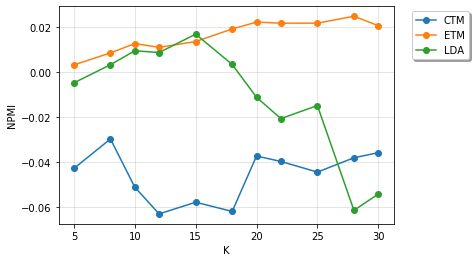

In [7]:
graph_data = [{ 'x': csv['k'], 'y': csv['c_npmi_test'] } for csv in [ctm_results, etm_results, lda_results]]
plot_coherence_by_k_graph(graph_data, ['CTM', 'ETM', 'LDA'])

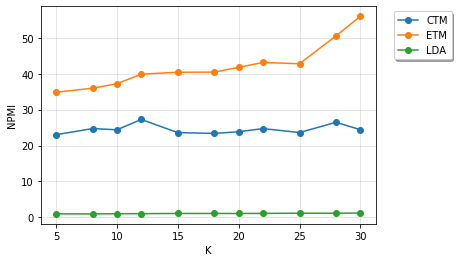

In [8]:
graph_data = [{ 'x': csv['k'], 'y': csv['train_time_in_seconds']/60 } for csv in [ctm_results, etm_results, lda_results]]
plot_coherence_by_k_graph(graph_data, ['CTM', 'ETM', 'LDA'])

### ETM com 28 tópicos

In [9]:
test_docs = json.load(open(TEST_DATASET, "r"))["split"]
dictionary = joblib.load(DICTIONARY)

Tópico 0: 


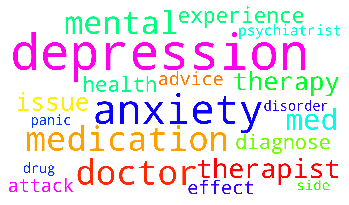

Tópico 1: 


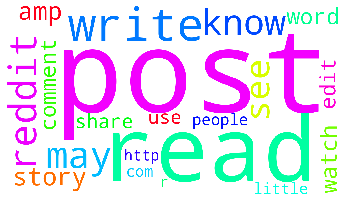

Tópico 2: 


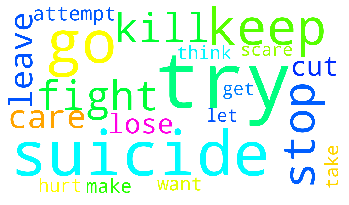

Tópico 3: 


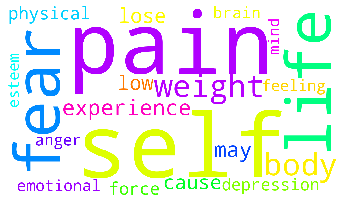

Tópico 4: 


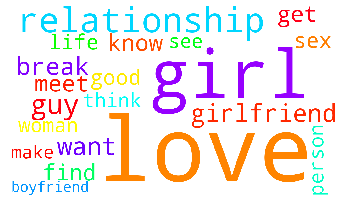

Tópico 5: 


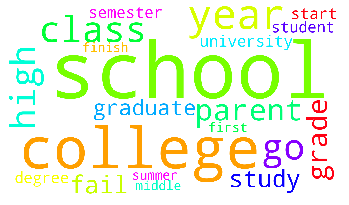

Tópico 6: 


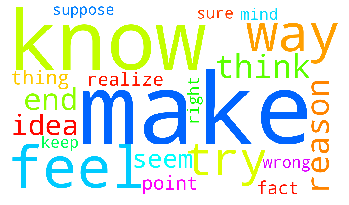

Tópico 7: 


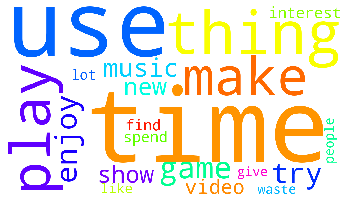

Tópico 8: 


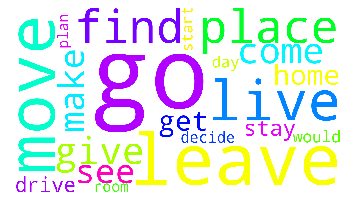

Tópico 9: 


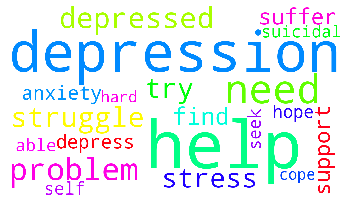

Tópico 10: 


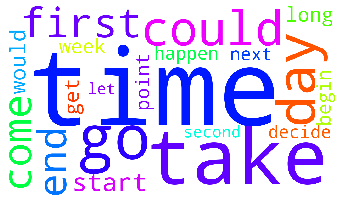

Tópico 11: 


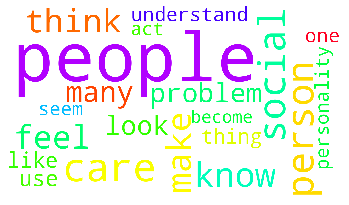

Tópico 12: 


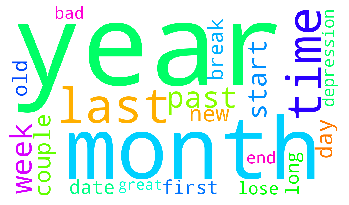

Tópico 13: 


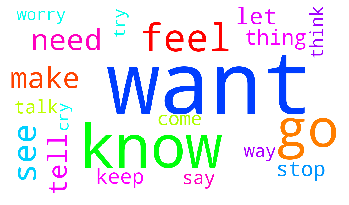

Tópico 14: 


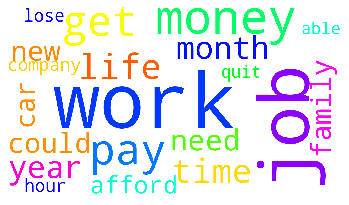

Tópico 15: 


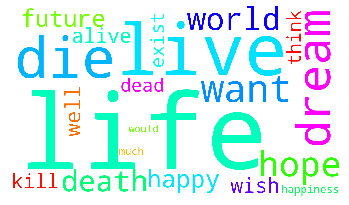

Tópico 16: 


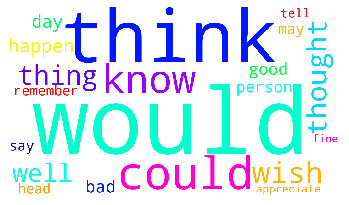

Tópico 17: 


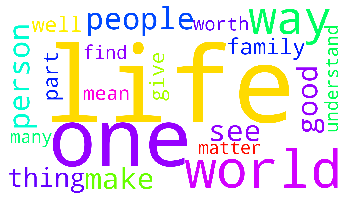

Tópico 18: 


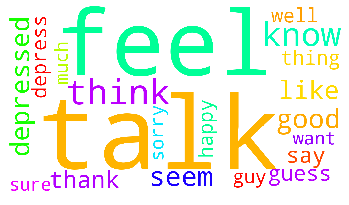

Tópico 19: 


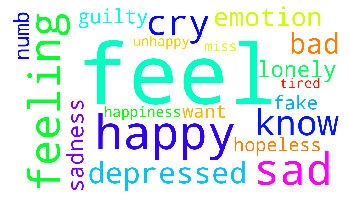

Tópico 20: 


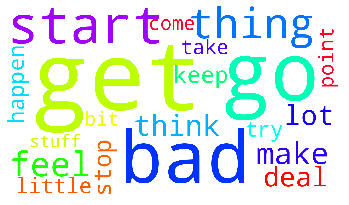

Tópico 21: 


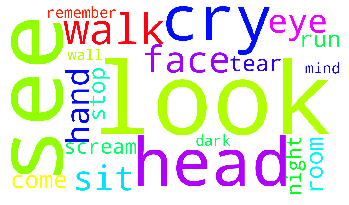

Tópico 22: 


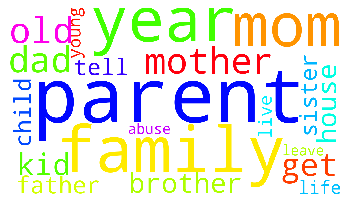

Tópico 23: 


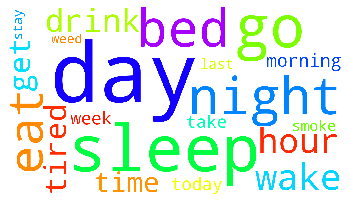

Tópico 24: 


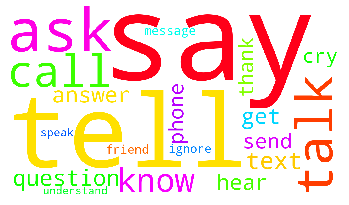

Tópico 25: 


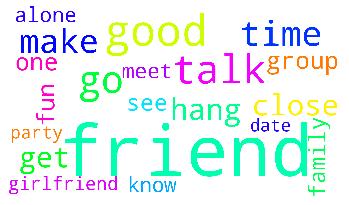

Tópico 26: 


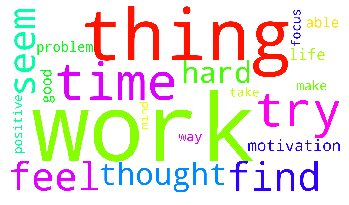

Tópico 27: 


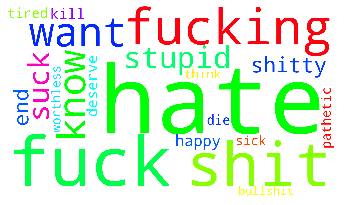

In [10]:
etm_best_model_path = etm_results_by_coherence['path'].tolist()[0]
etm1 = joblib.load(os.path.join(MODELS_PATH, etm_best_model_path))

etm_topics_probs = [topic[:WORDS_PER_TOPIC] for topic in etm1['topics_with_word_probs']]
etm_mapping = get_word_probability_mappings(etm_topics_probs)

coherence_by_topic = get_coherence_score_for_each_topic(etm1["topics"], test_docs, dictionary)

for idx, mapping in enumerate(etm_mapping):
    print(f'Tópico {idx}: ')
    plot_wordcloud_by_word_probability(etm_mapping[idx], f'etm_topic={idx+1}')

##### Rótulos possíveis para os tópicos:

Tópico 0: acompanhamento de saúde mental<br>
1: reddit<br>
2: angústia emocional<br>
3: baixa autoestima<br>
4: relacionamentos amorosos<br>
5: vida estudantil<br>
6: introspecção<br>
7: hobbies / entretenimento<br>
8: <br>
9: busca por ajuda / dificuldades com problemas mentais<br>
10: <br>
11: sociabilidade<br>
12: frequência temporal<br>
13: <br>
14: vida profissional<br>
15: vida futura / planejamento de longo-prazo<br>
16: ruminação<br>
17: pessoas<br>
18: <br>
19: emoções / sentimentos<br>
20: <br>
21: <br>
22: família<br>
23: rotina diária<br>
24: atitudes / ações<br>
25: amizades<br>
26: aconselhamento<br>
27: palavras negativas<br>

In [11]:
topics_coherence_table = pd.DataFrame(coherence_by_topic, columns=["npmi"])
topics_coherence_table.sort_values(["npmi"], ascending=(False))

,npmi
5,0.096122
0,0.090807
22,0.071539
1,0.060227
23,0.059759
24,0.038913
15,0.038258
21,0.034008
27,0.027033
7,0.026105


### Distribuição espacial dos tópicos dos modelos com melhor coerência usando t-SNE

#### ETM

A figura a seguir exibe a visualização gráfica dos modelo ETM com melhor coerência, onde K=28 tópicos.

In [12]:
#plot_tsne_graph_for_model(etm1, "ETM_K=28")

### Categorias léxicas dos tópicos do modelo usando Empath

#### ETM

In [13]:
counts = get_empath_categories_for_topics(etm1, normalize=True)
print(f'Categorias encontradas: {len(counts)}')

Categorias encontradas: 143


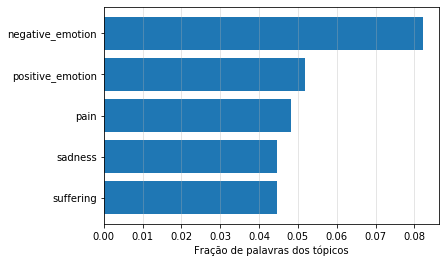

In [14]:
plot_lexical_categories_histogram(counts, topn=5)

In [15]:
get_raw_empath_categories_for_topics(etm1)

[{'depression': ['health', 'suffering', 'neglect', 'sadness'],
  'anxiety': ['health', 'nervousness', 'fear', 'sadness'],
  'doctor': ['medical_emergency', 'occupation', 'health', 'white_collar_job'],
  'medication': ['medical_emergency', 'health', 'healing'],
  'mental': ['health'],
  'med': ['health'],
  'therapist': ['office', 'occupation', 'health', 'work', 'white_collar_job'],
  'therapy': ['health'],
  'issue': ['dispute'],
  'experience': ['love'],
  'health': ['medical_emergency', 'health'],
  'diagnose': ['medical_emergency', 'health'],
  'effect': [],
  'attack': ['aggression', 'kill', 'fight', 'war', 'weapon'],
  'advice': ['communication', 'trust'],
  'psychiatrist': ['occupation', 'health', 'white_collar_job'],
  'side': ['shape_and_size'],
  'panic': ['medical_emergency', 'nervousness', 'horror', 'fear'],
  'disorder': ['health'],
  'drug': []},
 {'post': ['social_media', 'internet'],
  'read': ['reading', 'communication', 'writing'],
  'write': ['journalism', 'reading', 